In [41]:
# import necessary packages
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

import nltk
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from nltk import FreqDist

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models, similarities, matutils

sns.set_style('ticks')

## Natural Language Processing Models
Now that the document-term matrices have been created, I will explore the data to ensure that the corpus is in a suitable format to run sentiment analysis.

In [2]:
# read in the cleaned data
data = pd.read_pickle('corpus.pkl')
data.head()

,id_str,created_at,screen_name,in_reply_to_status_id_str,in_reply_to_screen_name,favorite_count,retweet_count,text
0,1230661597519138816,2020-02-21 01:12:44+00:00,MKBHD,1.230659e+18,AlexRCamacho1,851,7,not shipping
1,1230648790526386176,2020-02-21 00:21:50+00:00,MKBHD,NaN,None,8204,297,ordered escobar fold never got iti ordered esc...
2,1230581789619519488,2020-02-20 19:55:36+00:00,MKBHD,1.230581e+18,harshb_,25,1,…
3,1230566950989942784,2020-02-20 18:56:38+00:00,MKBHD,1.230534e+18,AlijahSimon,170,2,android customization stuff
4,1230535104214294528,2020-02-20 16:50:05+00:00,MKBHD,1.230534e+18,andrewmartonik,245,2,it’s possible scale isn’t perfect ¯ツ¯


In [6]:
# instantiate word cloud
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

In [7]:
# Combine all of the tweets into a single string
all_tweets = [tweet for tweet in data['text']]
all_tweets = ' '.join(all_tweets)

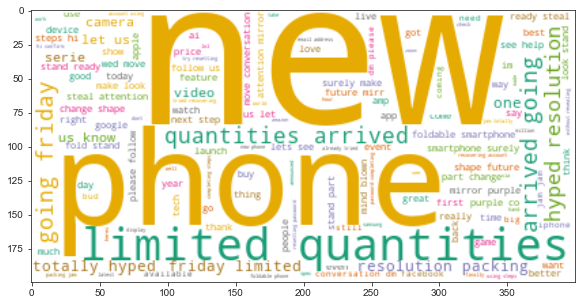

In [8]:
# generate word cloud from all tweets
cloud_tweets = wc.generate(all_tweets)

plt.figure(figsize=(10,5))
plt.imshow(cloud_tweets, interpolation='bilinear');

Dope! No words really stick out as outliers here. It looks like the major words are all relevant to the Samsung event and/or features of the phone which is exactly what I want.

## Sentiment Analysis
My main objective is to accurately assign sentiment scores to the tweets and determine which features/aspects of the phone corresponded to each emotion. 

In [9]:
sentiment_df = data.copy()

In [10]:
sentiment_df['day'] = sentiment_df['created_at'].dt.date
sentiment_df.head()

,id_str,created_at,screen_name,in_reply_to_status_id_str,in_reply_to_screen_name,favorite_count,retweet_count,text,day
0,1230661597519138816,2020-02-21 01:12:44+00:00,MKBHD,1.230659e+18,AlexRCamacho1,851,7,not shipping,2020-02-21
1,1230648790526386176,2020-02-21 00:21:50+00:00,MKBHD,NaN,None,8204,297,ordered escobar fold never got iti ordered esc...,2020-02-21
2,1230581789619519488,2020-02-20 19:55:36+00:00,MKBHD,1.230581e+18,harshb_,25,1,…,2020-02-20
3,1230566950989942784,2020-02-20 18:56:38+00:00,MKBHD,1.230534e+18,AlijahSimon,170,2,android customization stuff,2020-02-20
4,1230535104214294528,2020-02-20 16:50:05+00:00,MKBHD,1.230534e+18,andrewmartonik,245,2,it’s possible scale isn’t perfect ¯ツ¯,2020-02-20


In [11]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

sentiment_df['textblob_polarity'] = sentiment_df['text'].apply(pol)
sentiment_df['textblob_subjectivity'] = sentiment_df['text'].apply(sub)
sentiment_df.head()

,id_str,created_at,screen_name,in_reply_to_status_id_str,in_reply_to_screen_name,favorite_count,retweet_count,text,day,textblob_polarity,textblob_subjectivity
0,1230661597519138816,2020-02-21 01:12:44+00:00,MKBHD,1.230659e+18,AlexRCamacho1,851,7,not shipping,2020-02-21,0.0,0.0
1,1230648790526386176,2020-02-21 00:21:50+00:00,MKBHD,NaN,None,8204,297,ordered escobar fold never got iti ordered esc...,2020-02-21,0.0,0.0
2,1230581789619519488,2020-02-20 19:55:36+00:00,MKBHD,1.230581e+18,harshb_,25,1,…,2020-02-20,0.0,0.0
3,1230566950989942784,2020-02-20 18:56:38+00:00,MKBHD,1.230534e+18,AlijahSimon,170,2,android customization stuff,2020-02-20,0.0,0.0
4,1230535104214294528,2020-02-20 16:50:05+00:00,MKBHD,1.230534e+18,andrewmartonik,245,2,it’s possible scale isn’t perfect ¯ツ¯,2020-02-20,0.5,1.0


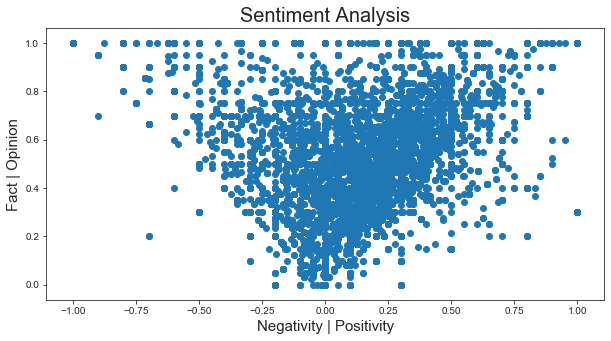

In [12]:
plt.figure(figsize=(10,5))

x = sentiment_df.textblob_polarity
y = sentiment_df.textblob_subjectivity
plt.scatter(x, y)
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('Negativity | Positivity', fontsize=15)
plt.ylabel('Fact | Opinion', fontsize=15);

### VADER Sentiment Analysis (Compound Scores)

In [13]:
analyzer = SentimentIntensityAnalyzer()
scores = []
for doc in sentiment_df['text']:
    vs = analyzer.polarity_scores(doc)
    scores.append(vs)

In [14]:
scores[:2]

[{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.14, 'neu': 0.86, 'pos': 0.0, 'compound': -0.2755}]

In [15]:
negative_scores = [score['neg'] for score in scores]
positive_scores = [score['pos'] for score in scores]
neutral_scores = [score['neu'] for score in scores]
compound_scores = [score['compound'] for score in scores]

In [16]:
sentiment_df['vader_neg'] = negative_scores
sentiment_df['vader_pos'] = positive_scores
sentiment_df['vader_neu'] = neutral_scores
sentiment_df['vader_compound'] = compound_scores
sentiment_df.head()

,id_str,created_at,screen_name,in_reply_to_status_id_str,in_reply_to_screen_name,favorite_count,retweet_count,text,day,textblob_polarity,textblob_subjectivity,vader_neg,vader_pos,vader_neu,vader_compound
0,1230661597519138816,2020-02-21 01:12:44+00:00,MKBHD,1.230659e+18,AlexRCamacho1,851,7,not shipping,2020-02-21,0.0,0.0,0.00,0.000,1.000,0.0000
1,1230648790526386176,2020-02-21 00:21:50+00:00,MKBHD,NaN,None,8204,297,ordered escobar fold never got iti ordered esc...,2020-02-21,0.0,0.0,0.14,0.000,0.860,-0.2755
2,1230581789619519488,2020-02-20 19:55:36+00:00,MKBHD,1.230581e+18,harshb_,25,1,…,2020-02-20,0.0,0.0,0.00,0.000,0.000,0.0000
3,1230566950989942784,2020-02-20 18:56:38+00:00,MKBHD,1.230534e+18,AlijahSimon,170,2,android customization stuff,2020-02-20,0.0,0.0,0.00,0.000,1.000,0.0000
4,1230535104214294528,2020-02-20 16:50:05+00:00,MKBHD,1.230534e+18,andrewmartonik,245,2,it’s possible scale isn’t perfect ¯ツ¯,2020-02-20,0.5,1.0,0.00,0.425,0.575,0.5719


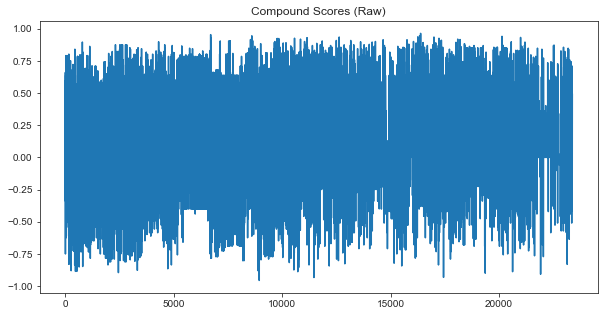

In [17]:
plt.figure(figsize=(10,5))
plt.plot(compound_scores)
plt.title('Compound Scores (Raw)');

In [18]:
sentiment_df['vader_neg_rolling'] = sentiment_df['vader_neg'].rolling(5, center=True).mean()
sentiment_df['vader_pos_rolling'] = sentiment_df['vader_pos'].rolling(5, center=True).mean()
sentiment_df['vader_neu_rolling'] = sentiment_df['vader_neu'].rolling(5, center=True).mean()
sentiment_df['vader_compound_rolling'] = sentiment_df['vader_compound'].rolling(5, center=True).mean()
sentiment_df.head()

,id_str,created_at,screen_name,in_reply_to_status_id_str,in_reply_to_screen_name,favorite_count,retweet_count,text,day,textblob_polarity,textblob_subjectivity,vader_neg,vader_pos,vader_neu,vader_compound,vader_neg_rolling,vader_pos_rolling,vader_neu_rolling,vader_compound_rolling
0,1230661597519138816,2020-02-21 01:12:44+00:00,MKBHD,1.230659e+18,AlexRCamacho1,851,7,not shipping,2020-02-21,0.0,0.0,0.00,0.000,1.000,0.0000,NaN,NaN,NaN,NaN
1,1230648790526386176,2020-02-21 00:21:50+00:00,MKBHD,NaN,None,8204,297,ordered escobar fold never got iti ordered esc...,2020-02-21,0.0,0.0,0.14,0.000,0.860,-0.2755,NaN,NaN,NaN,NaN
2,1230581789619519488,2020-02-20 19:55:36+00:00,MKBHD,1.230581e+18,harshb_,25,1,…,2020-02-20,0.0,0.0,0.00,0.000,0.000,0.0000,0.028,0.085,0.687,0.05928
3,1230566950989942784,2020-02-20 18:56:38+00:00,MKBHD,1.230534e+18,AlijahSimon,170,2,android customization stuff,2020-02-20,0.0,0.0,0.00,0.000,1.000,0.0000,0.028,0.085,0.687,0.05928
4,1230535104214294528,2020-02-20 16:50:05+00:00,MKBHD,1.230534e+18,andrewmartonik,245,2,it’s possible scale isn’t perfect ¯ツ¯,2020-02-20,0.5,1.0,0.00,0.425,0.575,0.5719,0.000,0.085,0.715,0.11438


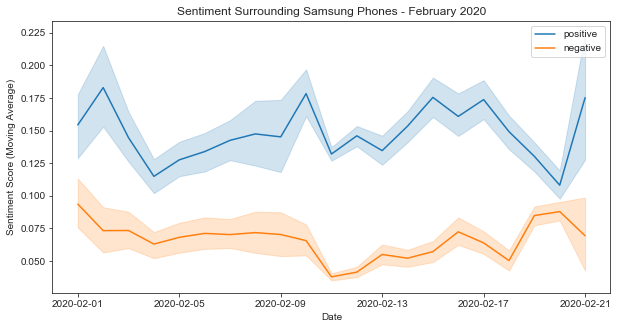

In [19]:
plt.figure(figsize=[10,5])
sns.lineplot(sentiment_df['created_at'].dt.date, sentiment_df['vader_pos'])
sns.lineplot(sentiment_df['created_at'].dt.date, sentiment_df['vader_neg'])
# sns.lineplot(sentiment_df['created_at'].dt.date, sentiment_df['vader_neu_rolling'])
plt.title('Sentiment Surrounding Samsung Phones - February 2020')
plt.xlabel('Date')
plt.ylabel('Sentiment Score (Moving Average)')
plt.legend(labels=['positive', 'negative']);

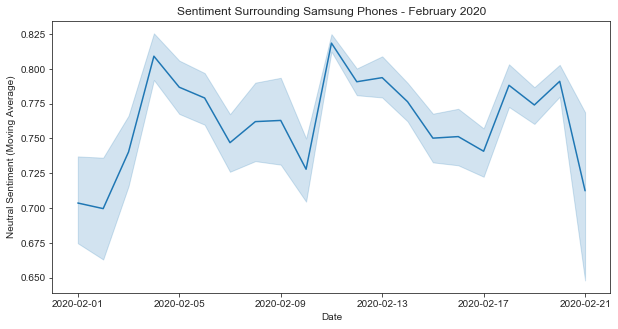

In [20]:
plt.figure(figsize=[10,5])
sns.lineplot(sentiment_df['created_at'].dt.date, sentiment_df['vader_neu'])
plt.title('Sentiment Surrounding Samsung Phones - February 2020')
plt.xlabel('Date')
plt.ylabel('Neutral Sentiment (Moving Average)');

## Sentiment over time
- Group by day and concatenate the tweets for that day into one document.
- Run sentiment analysis again on grouped data and plot with a line graph and curve/scatter.

<font color='blue'><h3>Rolling Avg</h3></font>

In [21]:
sentiment_df['textblob_polarity_rolling'] = sentiment_df['textblob_polarity'].rolling(5, center=True).mean()

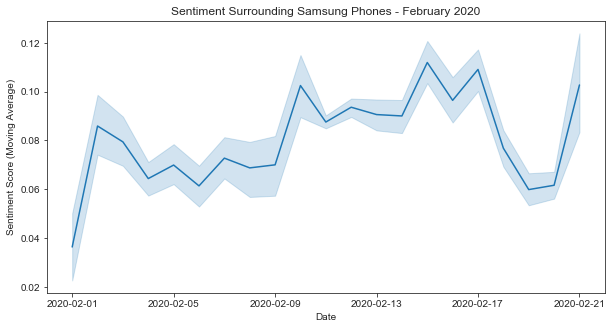

In [22]:
plt.figure(figsize=[10,5])
sns.lineplot(sentiment_df['created_at'].dt.date, sentiment_df['textblob_polarity_rolling'])
plt.title('Sentiment Surrounding Samsung Phones - February 2020')
plt.xlabel('Date')
plt.ylabel('Sentiment Score (Moving Average)');

<font color='blue'><h3>Means</h3></font>

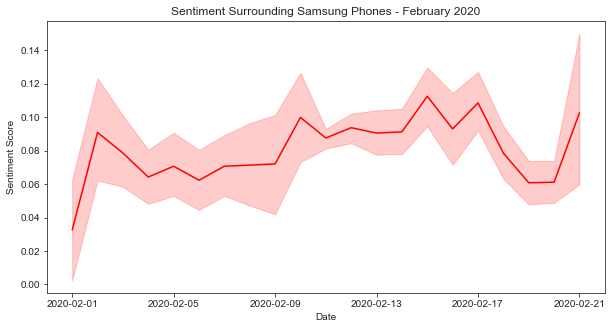

In [23]:
plt.figure(figsize=[10,5])
sns.lineplot(sentiment_df['created_at'].dt.date, sentiment_df['textblob_polarity'], color='red')
plt.title('Sentiment Surrounding Samsung Phones - February 2020')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.savefig('./images/plots/sentiment_avg.png', transparent=True);

In [53]:
# with plotly

# plt.figure(figsize=[10,5])
# px.line(sentiment_df['created_at'].dt.date, sentiment_df['textblob_polarity'])

# fig.update_layout({
#     'paper_bgcolor': 'rgba(0,0,0,0)'
# },
#     title={
#         'text': "Sentiment Surrounding Samsung Phones - February 2020",
#         'y':0.95,
#         'x':0.5,
#         'xanchor': 'center',
#         'yanchor': 'top'},
#     )

# fig.add_shape(
#         # Line Vertical
#         dict(
#             type="line",
#             x0='2019-02-11',
#             y0=0,
#             x1='2019-02-11',
#             y1=0.15,
#             line=dict(
#                 color="LightSeaGreen",
#                 width=3
#             )
# ))

# fig.add_annotation(
#             x='2011-02-01',
#             y=0.14,
#             text="Event Date")

# fig.update_xaxes(title_text='Date')
# fig.update_yaxes(title_text='Sentiment Score')
# fig.write_image("./images/plots/setiment_avg_plotly.png")

## Clustering

In [25]:
# read in the document-term matricex
data_count = pd.read_pickle('dtm_count.pkl')
data_count.head()

,aa,aaaaa,aaaaah,aaaaand,aaaawwww,aadmi,aakarsha,aapl,aaron,aayush,...,𝗮𝗻𝘆,𝗮𝘄𝗮𝘆,𝗳𝗮𝗰𝘂𝗹𝘁𝘆,𝗳𝗹𝘂𝘅,𝗶𝘀,𝗻𝗼𝘁,𝘁𝗮𝗸𝗲𝘀,𝘁𝗵𝗮𝘁,𝘂𝘀𝗲𝗱,𝙒𝙍𝙄
not shipping...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ordered escobar fold never got...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
…...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
android customization stuff...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
it’s possible scale isn’t perf...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
cls = MiniBatchKMeans(n_clusters=5, random_state=42)
cls.fit(np.array(data_count))

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

### PCA

In [27]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=42)
reduced_features = pca.fit_transform(np.array(data_count))

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

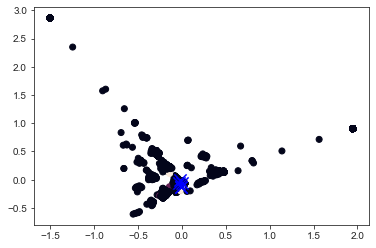

In [28]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(np.array(data_count)))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b');

### LDA

#### Pre-process text

In [29]:
# read in cleaned text to model
data = pd.read_pickle('corpus.pkl')
corpus = list(data.text)

In [30]:
# create a CountVectorizer
countVectorizer = CountVectorizer(stop_words='english')
countVectorizer.fit(corpus)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [31]:
# create the term-document matrix
doc_word = countVectorizer.transform(corpus).transpose()

In [32]:
# convert sparse matrix of counts to a gensim corpus
gensim_corpus = matutils.Sparse2Corpus(doc_word)

In [33]:
id2word = dict((v, k) for k, v in countVectorizer.vocabulary_.items())

#### Run LDA model

In [56]:
# # create lda model
# lda = models.LdaModel(corpus=gensim_corpus, num_topics=3, id2word=id2word, passes=100)

In [57]:
# lda_corpus = lda[corpus]

In [58]:
# lda_docs = [doc for doc in lda_corpus]
# lda_docs[0:5]

## NMF
Non-negative matrix factorization will work better for tweets as it removes the "weights" factor (sigma) from single variable decomposiiton, deconstructing the documennt-term matrix to doc-topics and topics-terms.

In [43]:
# create a CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
doc_word = vectorizer.fit_transform(corpus)

In [67]:
# instantiate nmf model
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(doc_word)

In [68]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [69]:
# display topics and words associated
display_topics(nmf_model, vectorizer.get_feature_names(), 10)


Topic  0
foldable, stand, look, smartphone, make, mirror, ready, purple, attention, surely

Topic  1
going, friday, limited, arrived, quantities, whats, tell, email, address, revealing

Topic  2
new, phone, video, phones, series, camera, night, foldable, samsung, generation

Topic  3
hi, know, steps, let, like, dm, follow, account, wed, confirm

Topic  4
resolution, totally, hyped, packing, im, hz, like, zoom, camera, id


### Generate word clouds for topics

In [100]:
feature_names = vectorizer.get_feature_names()
topic_words = []
for idx, topic in enumerate(nmf_model.components_):
    top_10 = ', '.join([feature_names[i] for i in topic.argsort()[:-21:-1]])
    topic_words.append(top_10)

In [101]:
topic_words

['foldable, stand, look, smartphone, make, mirror, ready, purple, attention, surely, steal, future, change, shape, fold, mirr, phone, help, lets, black',
 'going, friday, limited, arrived, quantities, whats, tell, email, address, revealing, hi, account, im, google, available, time, sale, year, phone, edition',
 'new, phone, video, phones, series, camera, night, foldable, samsung, generation, features, capture, best, smartphones, don, apple, buds, stop, light, watch',
 'hi, know, steps, let, like, dm, follow, account, wed, confirm, conversation, help, share, lets, hmm, try, using, recovering, tried, able',
 'resolution, totally, hyped, packing, im, hz, like, zoom, camera, id, video, high, record, display, mm, penis, love, apple, launched, thats']

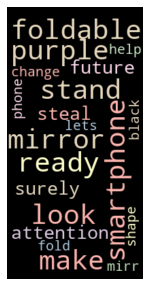

In [156]:
wc0 = WordCloud(width=200, height=400, background_color="black", colormap="Pastel1", max_font_size=150, random_state=42)
cloud0 = wc0.generate(topic_words[0])
plt.figure(figsize=(10,5))
plt.imshow(cloud0, interpolation='bilinear')
plt.axis('off')
plt.savefig('./images/plots/topic0_wc.png');

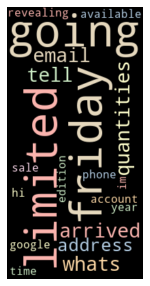

In [155]:
wc1 = WordCloud(width=200, height=400, background_color="black", colormap="Pastel1", max_font_size=150, random_state=42)
cloud1 = wc1.generate(topic_words[1])
plt.figure(figsize=(10,5))
plt.imshow(cloud1, interpolation='bilinear')
plt.axis('off')
plt.savefig('./images/plots/topic1_wc.png');

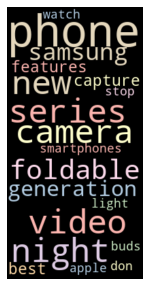

In [157]:
wc2 = WordCloud(width=200, height=400, background_color="black", colormap="Pastel1", max_font_size=150, random_state=42)
cloud2 = wc2.generate(topic_words[2])
plt.figure(figsize=(10,5))
plt.imshow(cloud2, interpolation='bilinear')
plt.axis('off')
plt.savefig('./images/plots/topic2_wc.png');

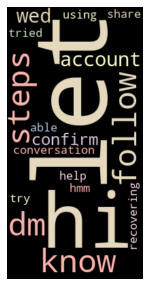

In [158]:
wc3 = WordCloud(width=200, height=400, background_color="black", colormap="Pastel1", max_font_size=150, random_state=42)
cloud3 = wc3.generate(topic_words[3])
plt.figure(figsize=(10,5))
plt.imshow(cloud3, interpolation='bilinear')
plt.axis('off')
plt.savefig('./images/plots/topic3_wc.png');

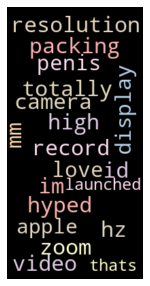

In [159]:
wc4 = WordCloud(width=200, height=400, background_color="black", colormap="Pastel1", max_font_size=150, random_state=42)
cloud4 = wc4.generate(topic_words[4])
plt.figure(figsize=(10,5))
plt.imshow(cloud4, interpolation='bilinear')
plt.axis('off')
plt.savefig('./images/plots/topic4_wc.png');

## LSA

In [70]:
# cv = CountVectorizer(stop_words=stop_words, ngram_range=(2,3), min_df = 10, max_df = 0.85)
cv = CountVectorizer(stop_words='english')
vectorized = cv.fit_transform(data['text'])
n_topics = 5
lsa = TruncatedSVD(n_topics)
doc_topic = lsa.fit_transform(vectorized)
lsa.explained_variance_ratio_
topics = pd.DataFrame(lsa.components_.round(3),
             index = ["component_" + str(i) for i in range(0, n_topics)],
             columns = cv.get_feature_names())
topics
display_topics(lsa, cv.get_feature_names(), 10)


Topic  0
new, foldable, going, look, smartphone, stand, friday, make, limited, arrived

Topic  1
going, friday, limited, arrived, quantities, tell, whats, address, revealing, email

Topic  2
new, phone, video, let, know, like, night, series, phones, camera

Topic  3
hi, know, steps, let, like, dm, follow, account, confirm, wed

Topic  4
resolution, totally, hyped, packing, im, like, hz, zoom, id, video


## UMap

/Users/baka_brooks/anaconda3/envs/metis/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/metis/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^


/Users/baka_brooks/anaconda3/envs/metis/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 31 separate connected components using meta-embedding (experimental)



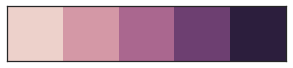

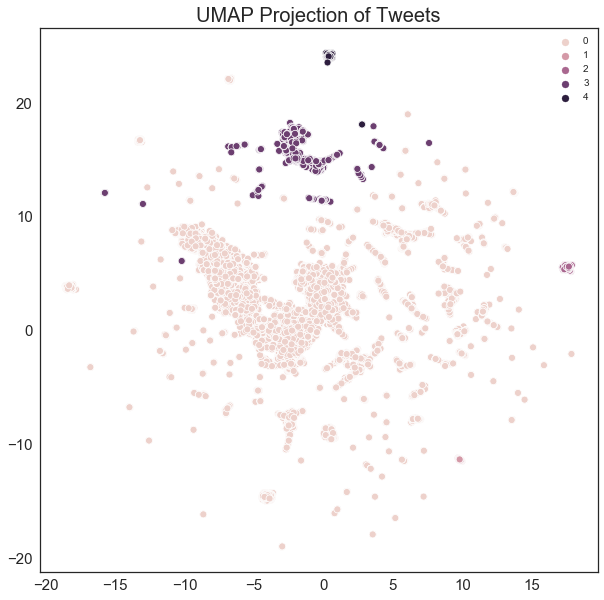

In [42]:
import umap

svd_model = TruncatedSVD(n_topics)
svd_model.fit(vectorized)

X_topics = svd_model.fit_transform(vectorized)

# Instantiate the clustering model
# clusters = KMeans(n_clusters=10)
# clusters.fit(X_topics)
# ypred = clusters.fit_predict(X_topics)
kmeans_labels = KMeans(n_clusters=5, n_jobs = -1).fit_predict(X_topics)

embedding = umap.UMAP(random_state=42).fit_transform(X_topics)

num_labels = len(set(kmeans_labels))

spectral = sns.palplot(sns.cubehelix_palette(num_labels))

plt.figure(figsize=(10,10))
sns.scatterplot(embedding[:, 0], embedding[:, 1], hue=kmeans_labels, cmap=spectral, legend = 'full')
plt.title('UMAP Projection of Tweets', fontsize=20)
plt.tick_params(labelsize=15)
plt.savefig('./images/plots/umap.png', transparent=True);